In [130]:
import glob
from os.path import abspath 
import json

import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,8)})

# --- open several .csv files
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- unzip non-dominated results into rows
def explode_ndf(df):
    df['zip'] = df[['ndf_f', 'ndf_x']].apply(lambda row: list(zip(*row.values)), axis=1)
    df.drop(['ndf_f', 'ndf_x'], axis=1, inplace=True)
    df = df.explode('zip')
    
    df = pd.concat([df.reset_index(drop=True), 
               pd.DataFrame.from_records(df['zip'].values, columns=['obj', 'params'])],
              axis=1).drop('zip', 1)
    
    # --- column for each objective     
    obj_df = pd.DataFrame.from_records(df['obj'].values, columns=df['objectives'].iloc[0])
    df = pd.concat([df.reset_index(drop=True), obj_df],
          axis=1).drop(['obj', 'objectives'], 1)

    return df   

In [131]:
raw_df = get_data("results_paper/open_ml_31/GaussianProcessRegressor_2_RF.*.pkl")
raw_df

,iteration,problem,objectives,feature_dim,ndf_size,ndf_f,ndf_x,i_time,model_id
0,1,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,2,"[[0.7667350182800826, 0.027927557627360027], [...","[[entropy, 60.0, 0.2037250044368072, 0.0824911...",36.473726,139643527543216
1,2,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,2,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",54.516037,139643527543216
2,3,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,2,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",73.217416,139643527543216
3,4,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,3,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",101.313956,139643527543216
4,5,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,3,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",146.970307,139643527543216
...,...,...,...,...,...,...,...,...,...
95,96,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.4793162393162393, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",39867.932828,140446023050160
96,97,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.4793162393162393, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",40952.712061,140446023050160
97,98,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.4793162393162393, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",41665.467797,140446023050160
98,99,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.4793162393162393, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",42464.418029,140446023050160


In [132]:
df = get_data("results_paper/open_ml_31/GaussianProcessRegressor_2_RF.*.pkl")
df = explode_ndf(df)
df

,iteration,problem,feature_dim,ndf_size,i_time,model_id,params,test_roc_auc,fit_time
0,1,GaussianProcessRegressor,7,2,36.473726,139643527543216,"[entropy, 60.0, 0.2037250044368072, 0.08249117...",0.766735,0.027928
1,1,GaussianProcessRegressor,7,2,36.473726,139643527543216,"[entropy, 60.0, 0.9999850442497041, 0.08249117...",0.500000,0.030146
2,2,GaussianProcessRegressor,7,2,54.516037,139643527543216,"[entropy, 18.167899779948602, 0.99999998799928...",0.500000,0.026118
3,2,GaussianProcessRegressor,7,2,54.516037,139643527543216,"[entropy, 36.924408920011196, 0.99999982565311...",0.500000,0.026265
4,3,GaussianProcessRegressor,7,2,73.217416,139643527543216,"[entropy, 18.167899779948602, 0.99999998799928...",0.500000,0.026118
...,...,...,...,...,...,...,...,...,...
3307,100,GaussianProcessRegressor,7,5,43605.562063,140446023050160,"[entropy, 17.038132538160763, 5.45452388776845...",0.479316,0.043613
3308,100,GaussianProcessRegressor,7,5,43605.562063,140446023050160,"[gini, 39.09707059989364, 0.5179368427804467, ...",0.482165,0.019506
3309,100,GaussianProcessRegressor,7,5,43605.562063,140446023050160,"[gini, 39.565836410857244, 0.9098500428352563,...",0.500000,0.017494
3310,100,GaussianProcessRegressor,7,5,43605.562063,140446023050160,"[gini, 40.34477940406965, 0.10162135053195424,...",0.694426,0.016120


<AxesSubplot:xlabel='iteration', ylabel='ndf_size_%'>

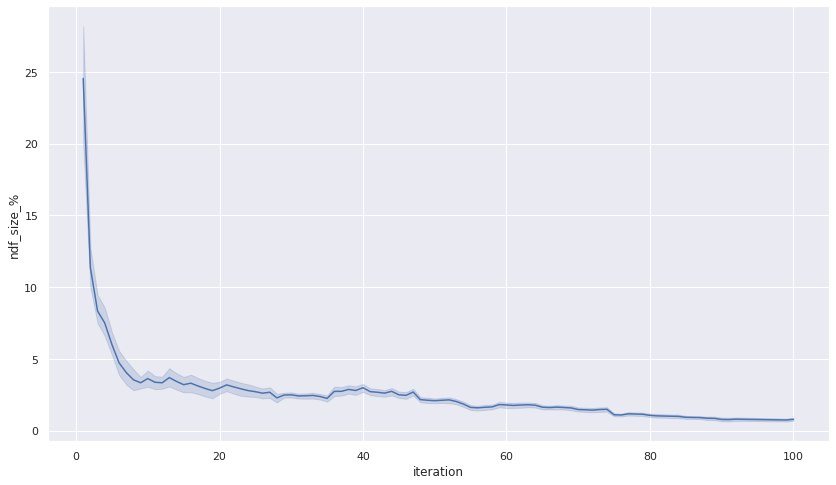

In [133]:
df['ndf_size_%'] = df['ndf_size'] / (df['iteration']*10) * 100
df['test_roc_auc_%'] = df['test_roc_auc'] * 100
df['fit_time_%'] = (1 - df['fit_time'] / df.max()["fit_time"]) * 100


sns.lineplot(x="iteration", 
             y="ndf_size_%", 
#              hue="model_id",
             data=df)

# sns.lineplot(x="iteration", 
#              y="test_roc_auc_%", 
# #              hue="model_id",
#              data=df)

# sns.lineplot(x="iteration", 
#              y="fit_time_%", 
# #              hue="model_id",
#              data=df)

# plt.legend(loc='upper left', labels=['ndf_size_%', 'test_roc_auc_%', 'fit_time_%'])

In [134]:
import numpy as np
#integrate using the trapezodial rule
np.trapz(y=df["ndf_size_%"], x=df["iteration"])

-3586.753607139564

In [135]:
# Hypervolume
# find a reference point = [1 - min roc_auc, max fit_time] 
# roc_auc is inversed for minimization

df.max()["fit_time"]
ref_point = np.array([1 - df.min()["test_roc_auc"], df.max()["fit_time"]])
ref_point

array([0.5247151 , 0.27828105])

In [136]:
#
def inverse(cell):
    for row in range(len(cell)):
        cell[row][0] = 1 - cell[row][0] 

In [137]:
raw_df["ndf_f"].apply(lambda x: inverse(x))

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: ndf_f, Length: 500, dtype: object

In [138]:
import pygmo as pg
# --- Update Hypervolume
def compute_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row["ndf_f"]).compute(ref_point) 
    row["hypervolume"] = hypervolume
    return row

In [139]:
raw_df = raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)
raw_df

,iteration,problem,objectives,feature_dim,ndf_size,ndf_f,ndf_x,i_time,model_id,hypervolume
0,1,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,2,"[[0.23326498171991739, 0.027927557627360027], ...","[[entropy, 60.0, 0.2037250044368072, 0.0824911...",36.473726,139643527543216,0.072966
1,2,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,2,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",54.516037,139643527543216,0.006232
2,3,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,2,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",73.217416,139643527543216,0.006232
3,4,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,3,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",101.313956,139643527543216,0.006232
4,5,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,3,"[[0.5, 0.026118357976277668], [0.5, 0.02626474...","[[entropy, 18.167899779948602, 0.9999999879992...",146.970307,139643527543216,0.006232
...,...,...,...,...,...,...,...,...,...,...
95,96,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.5206837606837607, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",39867.932828,140446023050160,0.057450
96,97,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.5206837606837607, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",40952.712061,140446023050160,0.057450
97,98,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.5206837606837607, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",41665.467797,140446023050160,0.057450
98,99,GaussianProcessRegressor,"[test_roc_auc, fit_time]",7,4,"[[0.5206837606837607, 0.04361287752787272], [0...","[[entropy, 17.038132538160763, 5.4545238877684...",42464.418029,140446023050160,0.057450


<AxesSubplot:xlabel='iteration', ylabel='hypervolume'>

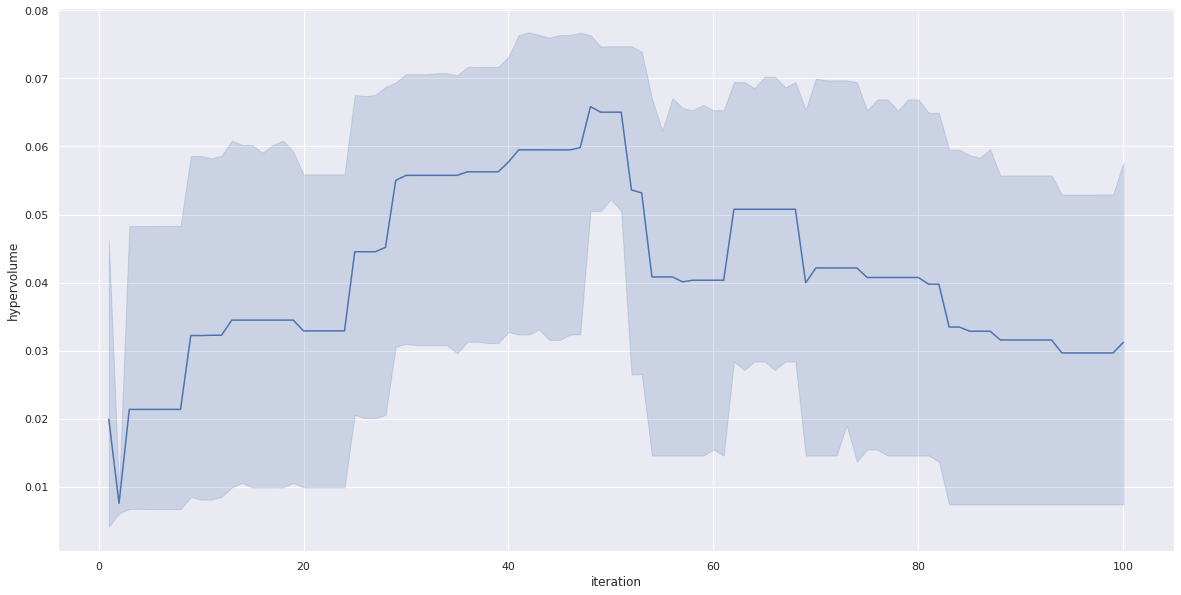

In [140]:
f, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x="iteration", 
             y="hypervolume", 
#              hue="model_id",
             data=raw_df)

# sns.lineplot(x="iteration", 
#              y="test_roc_auc_%", 
# #              hue="model_id",
#              data=df)

# sns.lineplot(x="iteration", 
#              y="fit_time_%", 
# #              hue="model_id",
#              data=df)

# plt.legend(loc='upper left', labels=['ndf_size_%', 'test_roc_auc_%', 'fit_time_%'])

<AxesSubplot:xlabel='iteration', ylabel='test_roc_auc'>

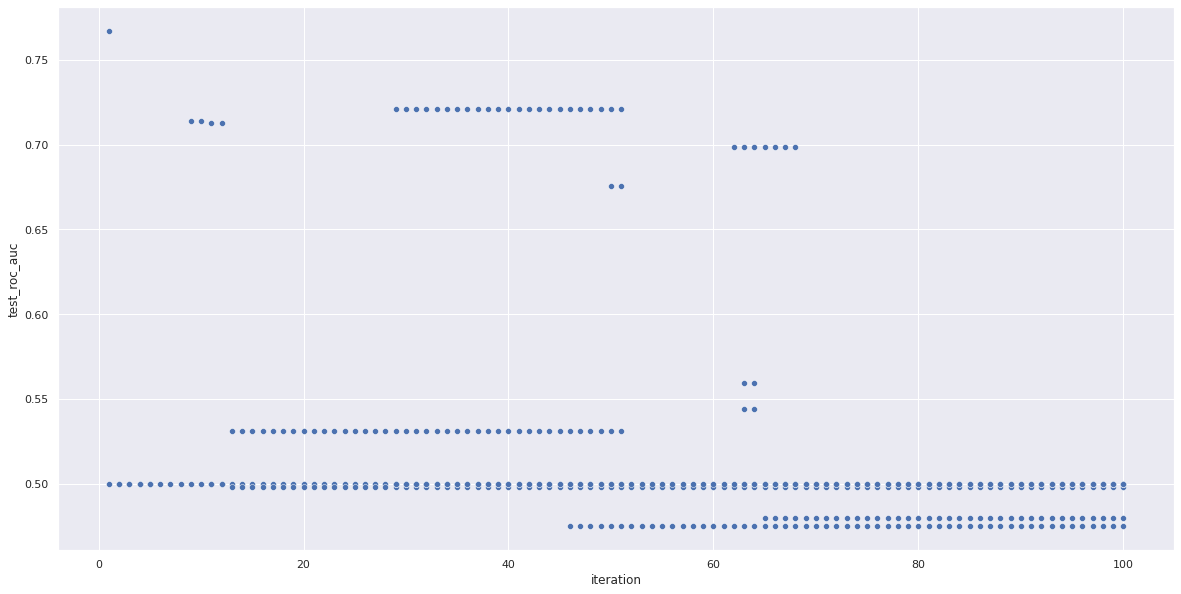

In [141]:
f, ax = plt.subplots(figsize=(20, 10))
df_single = df[df.model_id==139643527543216]

sns.scatterplot(x="iteration", y="test_roc_auc", data=df_single)

<AxesSubplot:xlabel='iteration', ylabel='fit_time'>

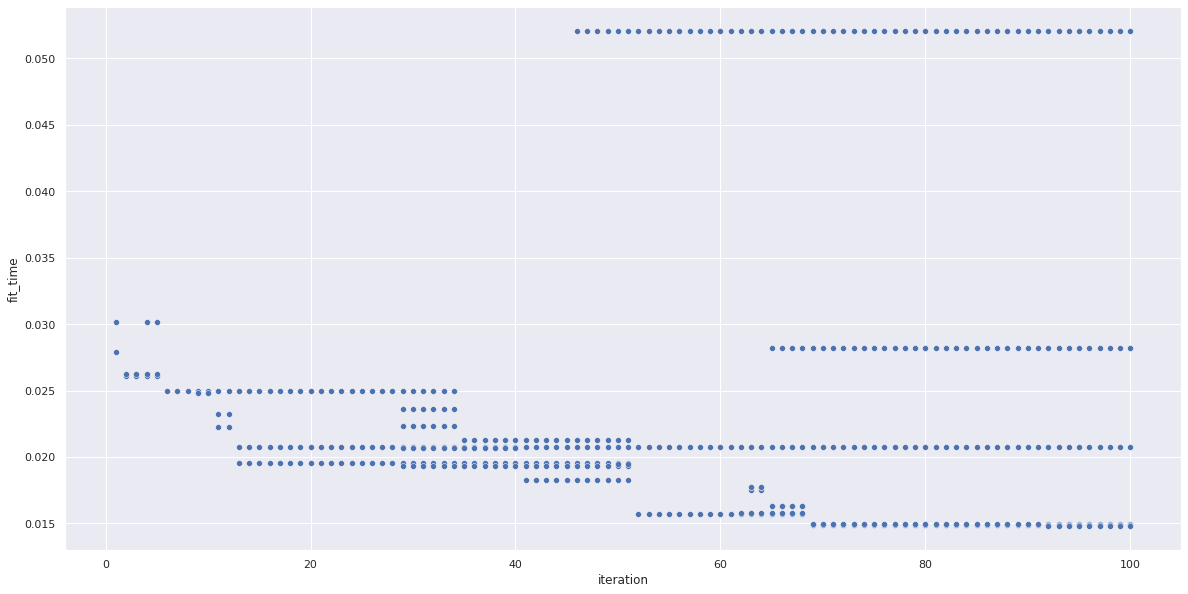

In [142]:
f, ax = plt.subplots(figsize=(20, 10))
df_single = df[df.model_id==139643527543216]

sns.scatterplot(x="iteration", y="fit_time", data=df_single)

<AxesSubplot:xlabel='iteration', ylabel='ndf_size'>

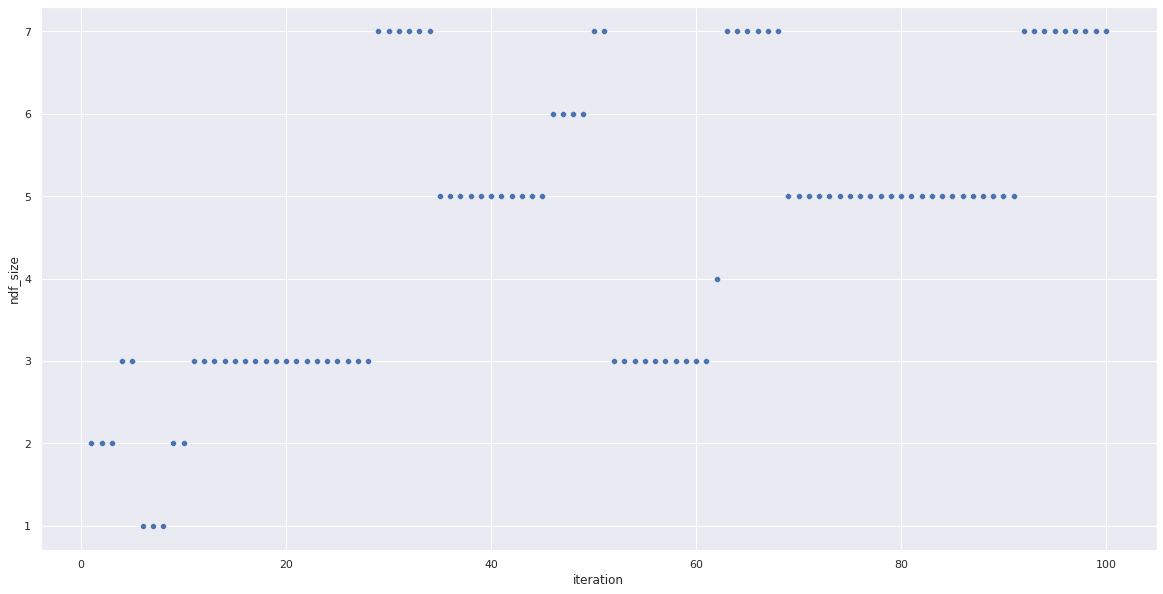

In [143]:
f, ax = plt.subplots(figsize=(20, 10))
df_single = df[df.model_id==139643527543216]

sns.scatterplot(x="iteration", y="ndf_size", data=df_single)

In [144]:
df = get_data("results_paper/open_ml_31/separate(GradientBoostingRegressor+GradientBoostingRegressor)_2_RF.*.pkl")
df = explode_ndf(df)
df

,iteration,problem,feature_dim,ndf_size,i_time,model_id,params,test_roc_auc,fit_time
0,1,separate(GradientBoostingRegressor+GradientBoo...,7,3,60.395366,140445992065008,"[gini, 38.0, 0.3125, 0.34375, 0.28125, sqrt, 71]",0.500000,0.133645
1,1,separate(GradientBoostingRegressor+GradientBoo...,7,3,60.395366,140445992065008,"[gini, 35.0, 0.3650585846340185, 0.22528562461...",0.699725,0.036783
2,1,separate(GradientBoostingRegressor+GradientBoo...,7,3,60.395366,140445992065008,"[gini, 35.0, 0.29248427551894607, 0.2252856246...",0.736227,0.038556
3,2,separate(GradientBoostingRegressor+GradientBoo...,7,3,121.858025,140445992065008,"[gini, 38.0, 0.3125, 0.34375, 0.28125, sqrt, 71]",0.500000,0.133645
4,2,separate(GradientBoostingRegressor+GradientBoo...,7,3,121.858025,140445992065008,"[gini, 35.0, 0.3650585846340185, 0.22528562461...",0.699725,0.036783
...,...,...,...,...,...,...,...,...,...
1372,99,separate(GradientBoostingRegressor+GradientBoo...,7,3,4778.259340,140329358602416,"[entropy, 110.63420317150467, 0.00051164768563...",0.500000,0.015359
1373,99,separate(GradientBoostingRegressor+GradientBoo...,7,3,4778.259340,140329358602416,"[gini, 22.315872762290002, 0.04791337042586142...",0.687614,0.015668
1374,100,separate(GradientBoostingRegressor+GradientBoo...,7,3,4829.580849,140329358602416,"[gini, 111.38019856584404, 0.01248282341185609...",0.702034,0.015585
1375,100,separate(GradientBoostingRegressor+GradientBoo...,7,3,4829.580849,140329358602416,"[entropy, 110.63420317150467, 0.00051164768563...",0.500000,0.015359


<AxesSubplot:xlabel='iteration', ylabel='test_roc_auc'>

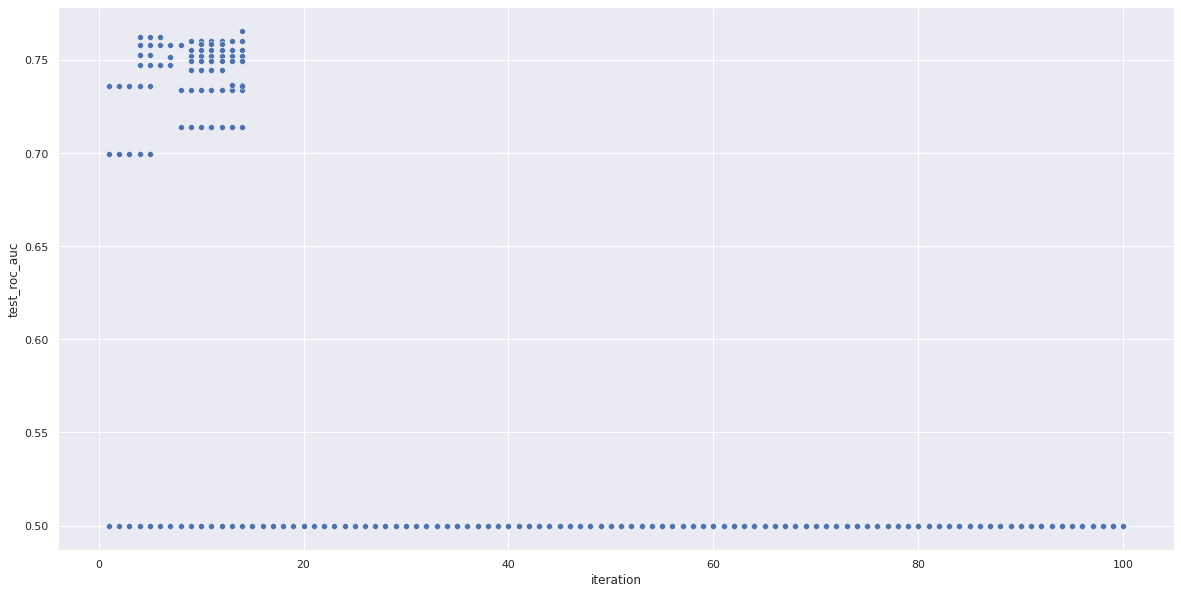

In [145]:
f, ax = plt.subplots(figsize=(20, 10))
df_single = df[df.model_id==140445992065008]

sns.scatterplot(x="iteration", y="test_roc_auc", data=df_single)

<AxesSubplot:xlabel='iteration', ylabel='fit_time'>

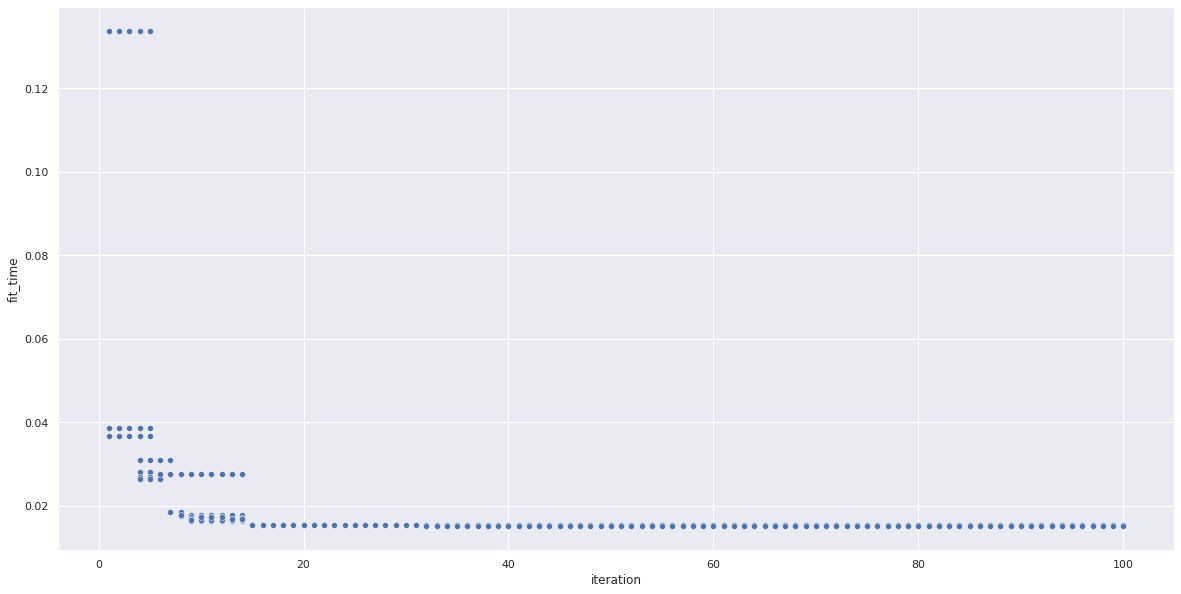

In [146]:
f, ax = plt.subplots(figsize=(20, 10))
df_single = df[df.model_id==140445992065008]

sns.scatterplot(x="iteration", y="fit_time", data=df_single)

<AxesSubplot:xlabel='iteration', ylabel='ndf_size'>

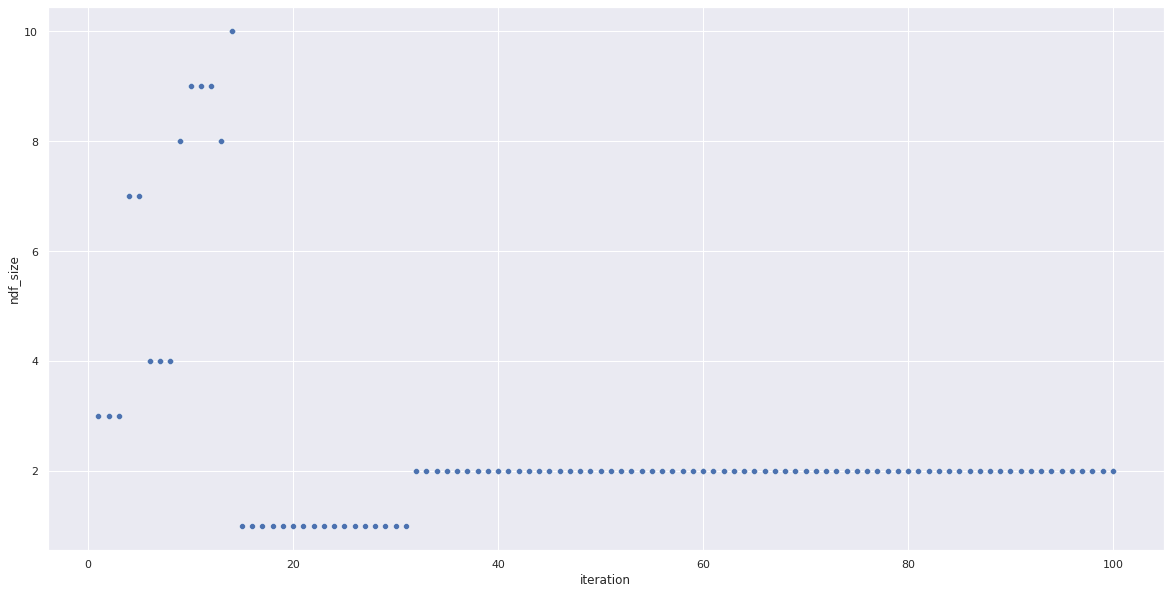

In [147]:
f, ax = plt.subplots(figsize=(20, 10))
df_single = df[df.model_id==140445992065008]

sns.scatterplot(x="iteration", y="ndf_size", data=df_single)

<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

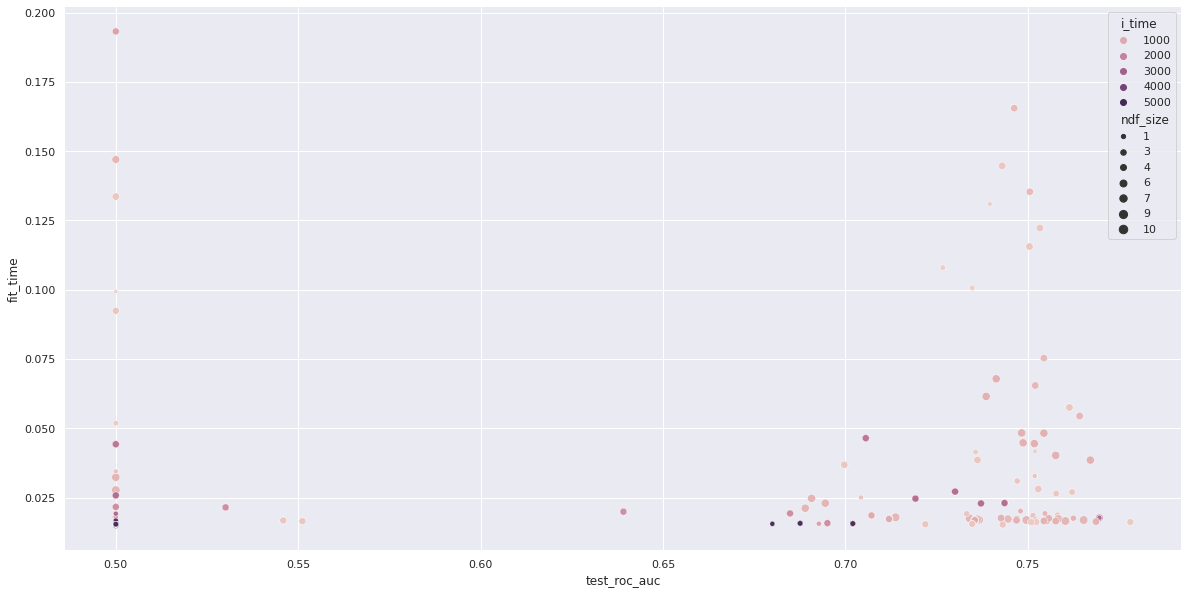

In [148]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                hue="i_time", size="ndf_size",
                data=df, ax=ax)

## Final results: all samples

In [149]:
data = get_data("results_paper/open_ml_1049/dataset.*.pkl")
data

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators,fit_time,score_time,test_f1,test_roc_auc
0,gini,61.000000,0.500000,2.500000e-01,2.500000e-01,sqrt,505,0.710772,0.094134,0.000000,0.858696
1,entropy,31.000000,0.750000,1.250000e-01,3.750000e-01,sqrt,752,0.972053,0.133970,0.000000,0.500000
2,gini,90.000000,0.250000,3.750000e-01,1.250000e-01,log2,257,0.373163,0.071908,0.000000,0.500000
3,gini,46.000000,0.625000,6.250000e-02,4.375000e-01,log2,133,0.186023,0.028879,0.000000,0.836822
4,entropy,105.000000,0.125000,3.125000e-01,1.875000e-01,sqrt,628,0.862586,0.116507,0.000000,0.788737
...,...,...,...,...,...,...,...,...,...,...,...
1005,gini,103.223420,0.064604,1.843850e-11,1.532728e-15,log2,632,1.096209,0.127250,0.206705,0.918618
1006,gini,103.223420,0.212864,1.843850e-11,4.859257e-14,log2,632,0.989894,0.122440,0.000000,0.892303
1007,gini,103.972264,0.011444,1.843850e-11,3.995099e-13,log2,632,1.187727,0.132995,0.377450,0.922851
1008,gini,102.908405,0.105250,1.658110e-11,7.332780e-14,log2,632,1.052771,0.125557,0.040404,0.908569


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

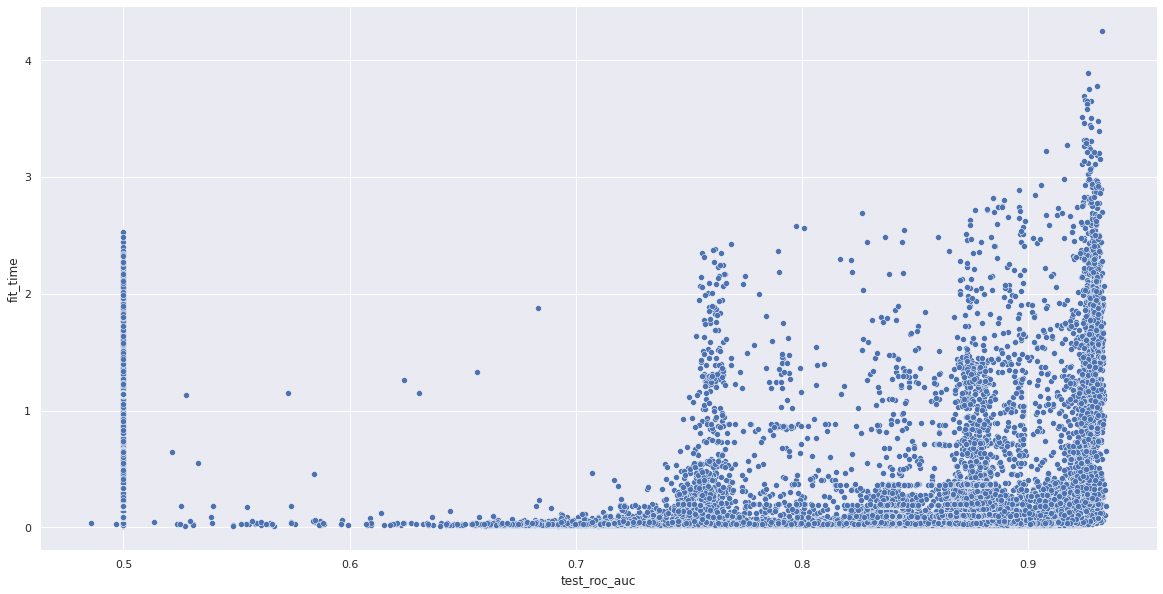

In [150]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                data=data, ax=ax)